In [15]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Add parent folder to Python path
import sys
import os

notebook_dir = os.path.abspath(os.path.dirname(os.path.realpath('__file__')))
parent_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))
sys.path.append(parent_dir)

from helpers.plotting.lr import plot_predictions

Machine learning is a game of two parts:

* 1) Turn your data, whatever it is, into numbers (a representation).
* 2) Pick or build a model to learn the representation as best as possible.

Let's start by creating some data and see how if we can find an algorithm to learn these representations.

In [27]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Text(0.5, 1.0, 'Perfect line to Predict:')

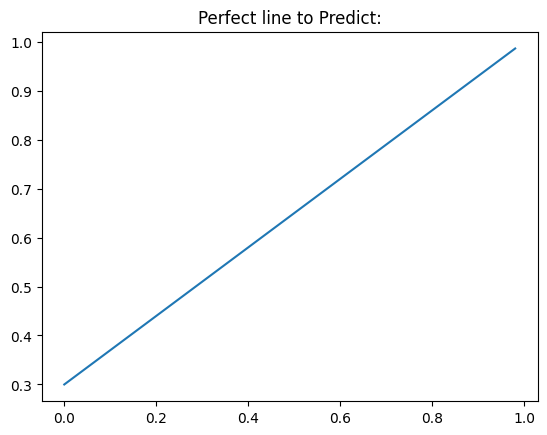

In [28]:
plt.plot(X, y)
plt.title('Perfect line to Predict:')

In [29]:
# Splitting into train-test datasets 

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Let's create a simple linear model using `pytorch`:

In [30]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

Let's start!

In [31]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

Inference mode is a torch `module` to enable inference using models:

In [32]:
with torch.inference_mode(): 
    y_preds = model_0(X_test)

We have some `y_preds` - are they working out? Unfortunately, no (our weights and biases are random!)

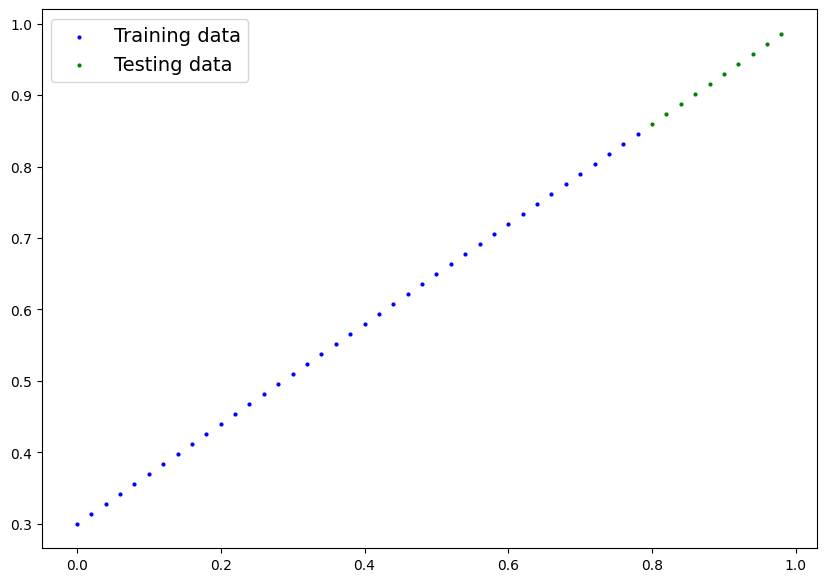

In [33]:
# First taking a peek at what we want to predict

plot_predictions(X_train, y_train, X_test, y_test)

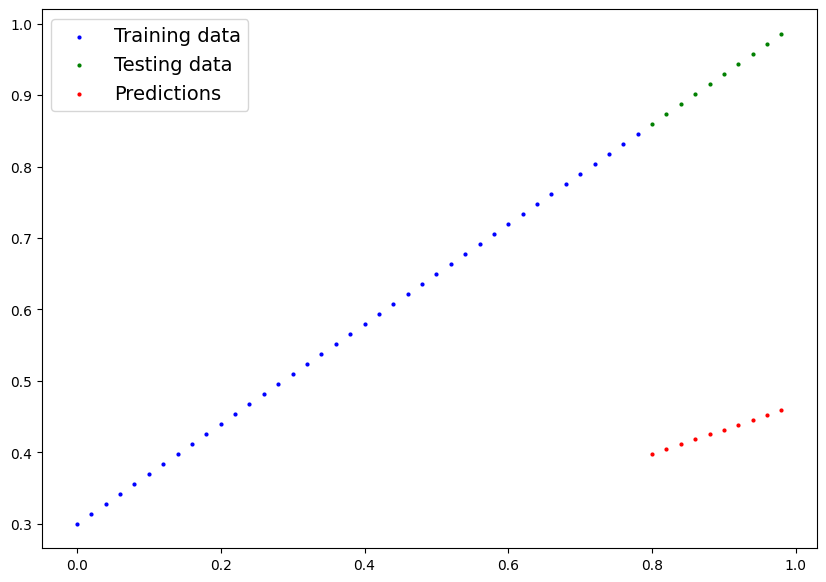

In [34]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

We want to bring our red dots as closer as possible to the green dots. This can be achieved by minimizing the error between both!

In [35]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss in Pytorch

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### The PyTorch Training Loop

How do we exactly train the model?

Using these steps:

* **1. Forward pass**. The model goes through all of the training data once, performing its forward() function calculations.	
* **2. Calculate the loss**	The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
* **3. Zero gradients.**	The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
* **4. Perform backpropagation on the loss.**	Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards".
* **5. Update the optimizer (gradient descent).**	Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.

Doing it in code:

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


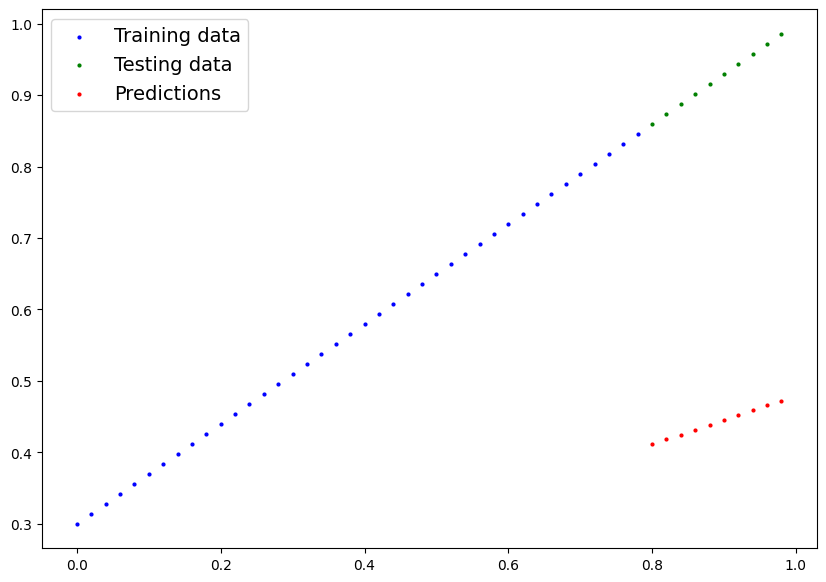

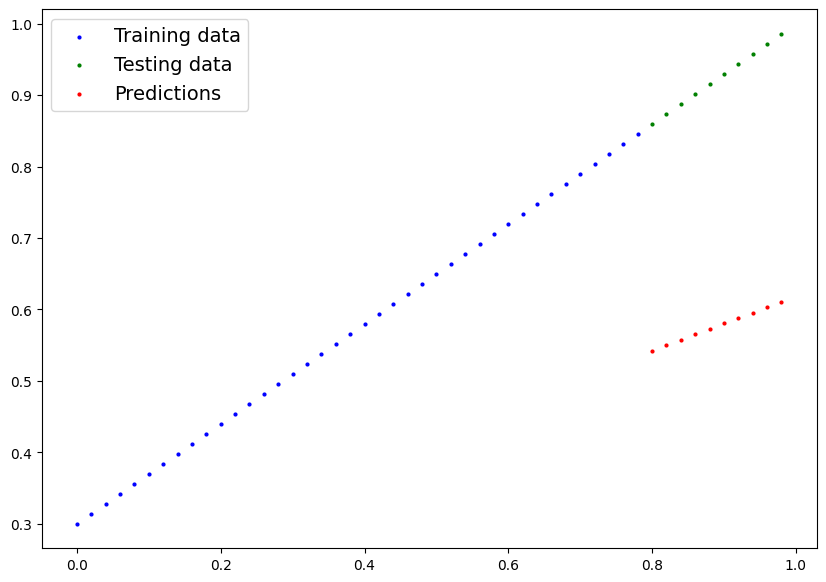

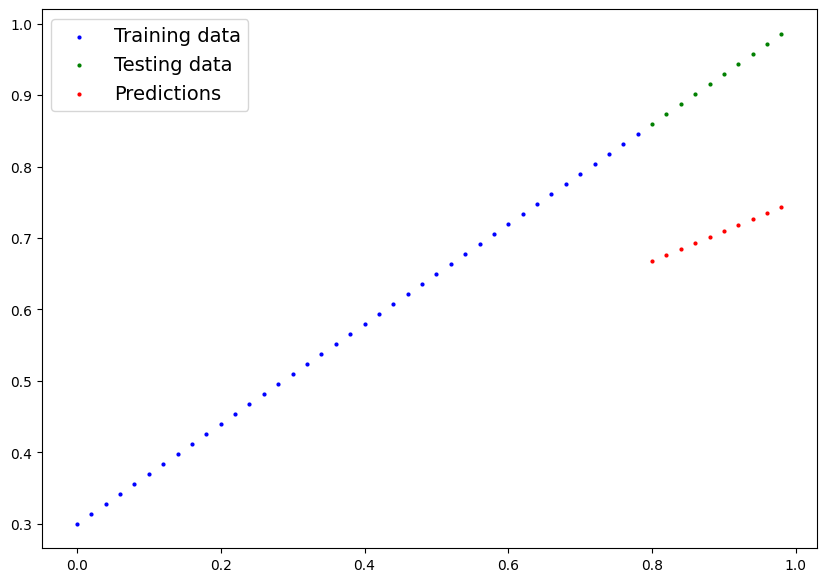

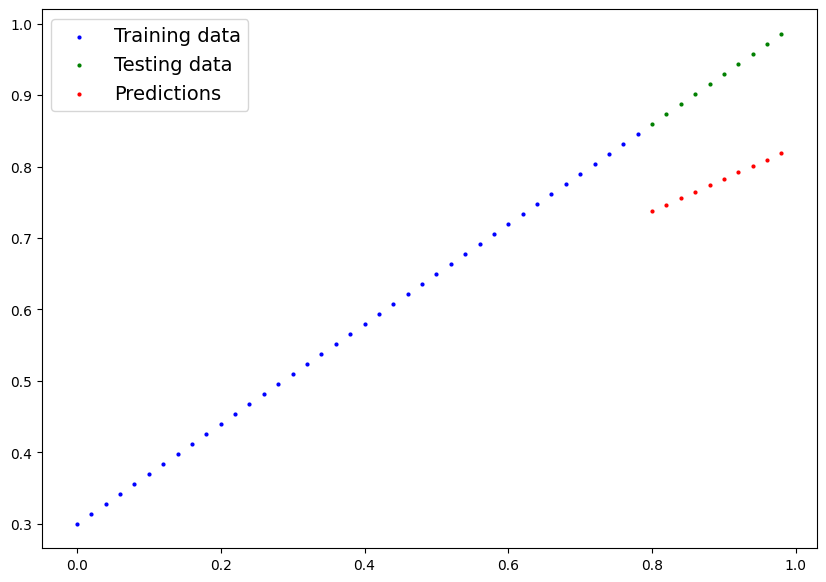

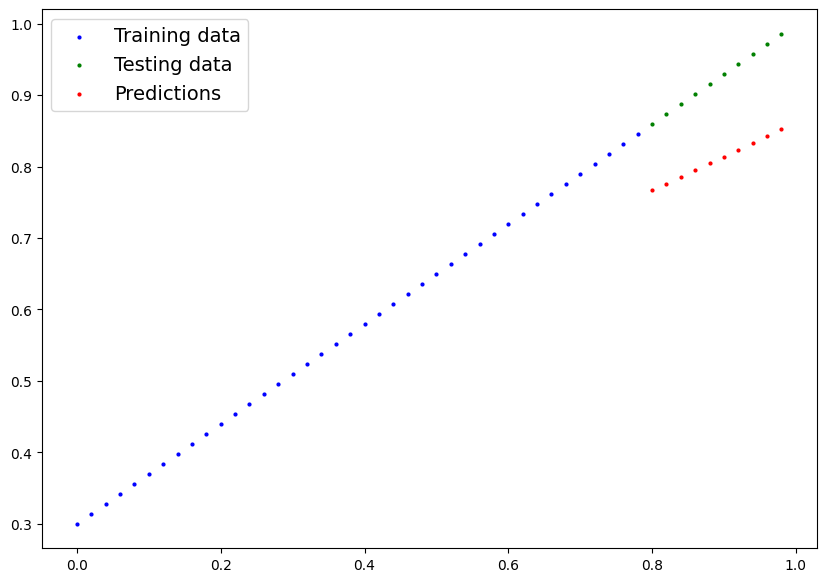

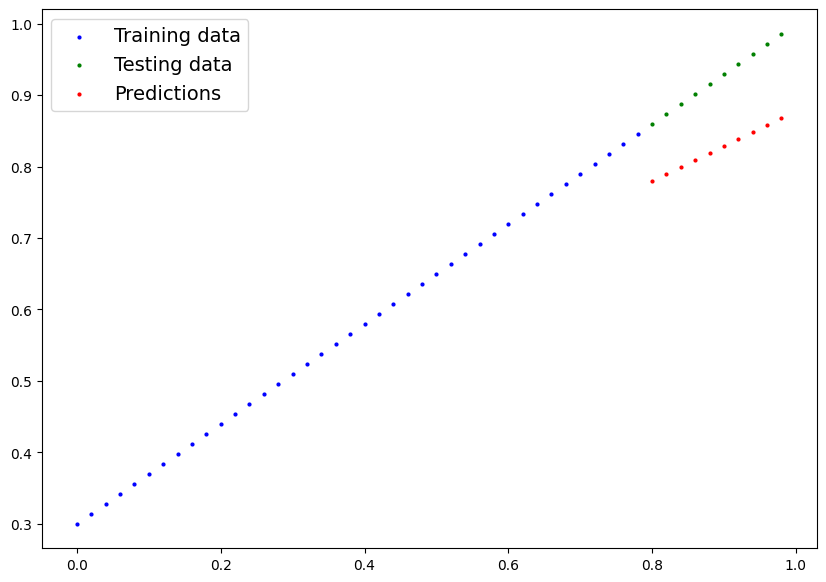

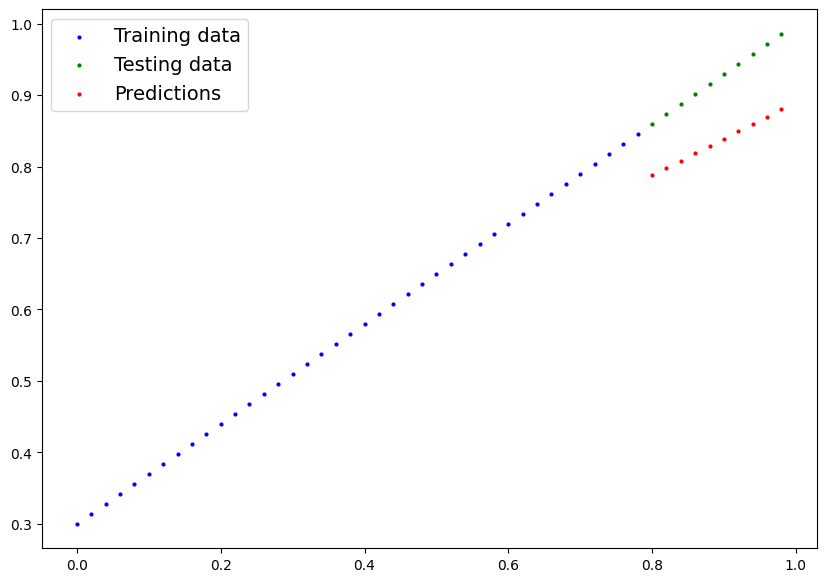

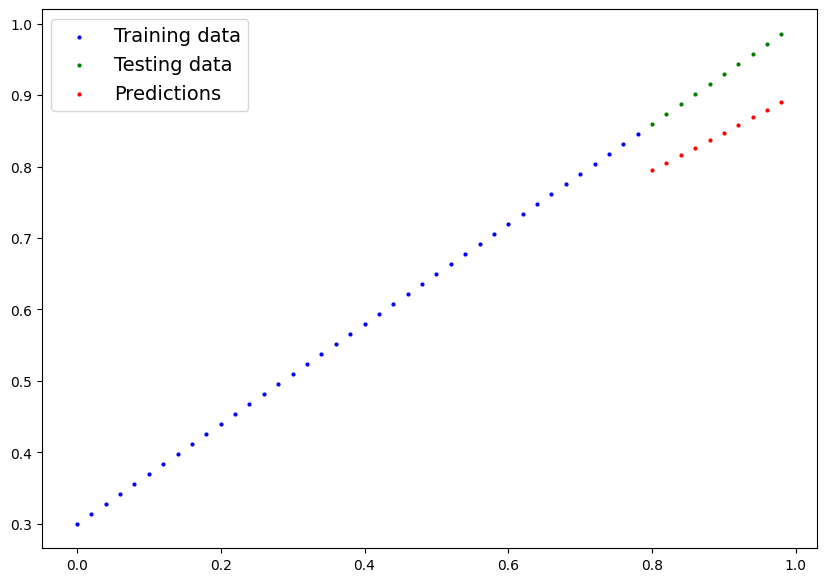

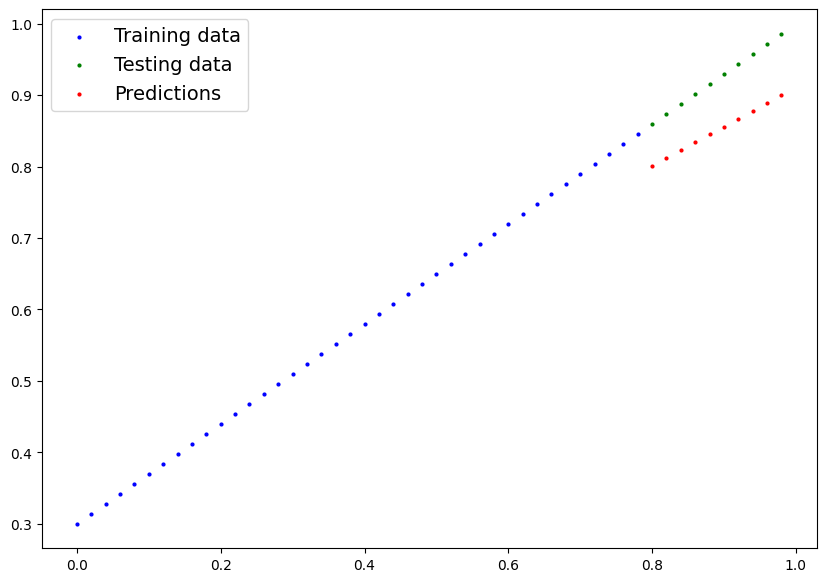

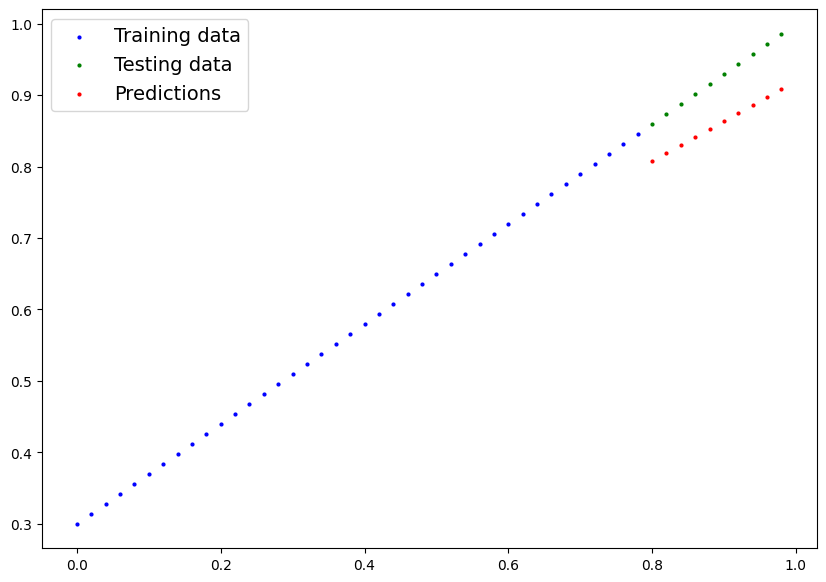

In [36]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(X_test)

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            
            # Notice how our red dots are getting closer and closer to the real target
            plot_predictions(X_train, y_train, X_test, y_test, test_pred)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

That's it - super simple!